In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Passing a retry policy to a node

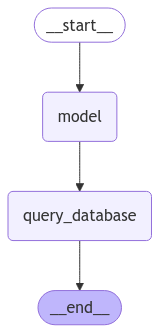

In [3]:
import operator
import sqlite3
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import AIMessage


from langgraph.pregel import RetryPolicy

RetryPolicy()

db = SQLDatabase.from_uri("sqlite:///:memory:")



class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


def query_database(state):
    query_result = db.run("SELECT * FROM Artist LIMIT 10;")
    return {"messages": [AIMessage(content=query_result)]}


def call_model(state):
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# Define a new graph
builder = StateGraph(AgentState)
builder.add_node(
    "query_database",
    query_database,
    retry=RetryPolicy(retry_on=sqlite3.OperationalError),
)
builder.add_node("model", call_model, retry=RetryPolicy(max_attempts=5))
builder.add_edge(START, "model")
builder.add_edge("model", "query_database")
builder.add_edge("query_database", END)

graph = builder.compile()

graph